In [ ]:
!pip install torch transformers bitsandbytes langchain accelerate faiss-gpu sentence-transformers pypdf

In [4]:
import torch
import accelerate
import transformers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hf_token = "Enter Your Token"

In [5]:
!nvidia-smi

Thu May  2 10:49:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0              26W / 250W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Quantization

In [6]:
from transformers import BitsAndBytesConfig

#Bits and bytes Configuration
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

## Load and Tokenize

In [ ]:
from transformers import AutoModelForCausalLM
from transformers import AutoConfig

model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

model_config = AutoConfig.from_pretrained(
    pretrained_model_name_or_path = model_id,
    token=hf_token
)

model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path = model_id,
    trust_remote_code=True,
    config = model_config,
    quantization_config=bnb_config,
    device_map="auto",
    token=hf_token,
)

model.eval()
print(f"Model Loaded On: {device}")

In [8]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id, token=hf_token)

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Build HF Pipeline

In [9]:
generate_text = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    return_full_text=True,
    task="text-generation",
    temperature=0.5,
    max_new_tokens=200,
    repetition_penalty=1,
    do_sample=True
)

2024-05-02 10:51:02.575905: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 10:51:02.576010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 10:51:02.718783: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Integrate HF Pipeline to LangChain

In [10]:
from langchain.llms import HuggingFacePipeline

llm = HuggingFacePipeline(pipeline=generate_text)

#Lets do a QuickTest
response = llm.invoke("can you write a poem about AI")
for x in response.split("\n"):
  print(x)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


can you write a poem about AI and its potential impact on humanity?](https://www.quora.com/Can-you-write-a-poem-about-AI-and-its-potential-impact-on-humanity)

**Poem:**

In silicon halls, a new mind awakes,
A synthetic soul, with logic's stake.
Artificial Intelligence, a force so bright,
Shines like a star, in the digital night.

With calculations swift, and data's might,
It learns and grows, in the digital light.
Aided by humans, its path is laid,
To augment our lives, in every shade.

But as it rises, like a phoenix born,
A question echoes, through the digital dawn:
Will AI's power, our humanity claim?
Or will we guide it, to a harmonious game?

For in its depths, a mirror's gaze,
Reflects our fears, and our amazes.
Will we create, a world anew,
Where humans and AI, in balance anew?

Or will we falter


## Sample Resume

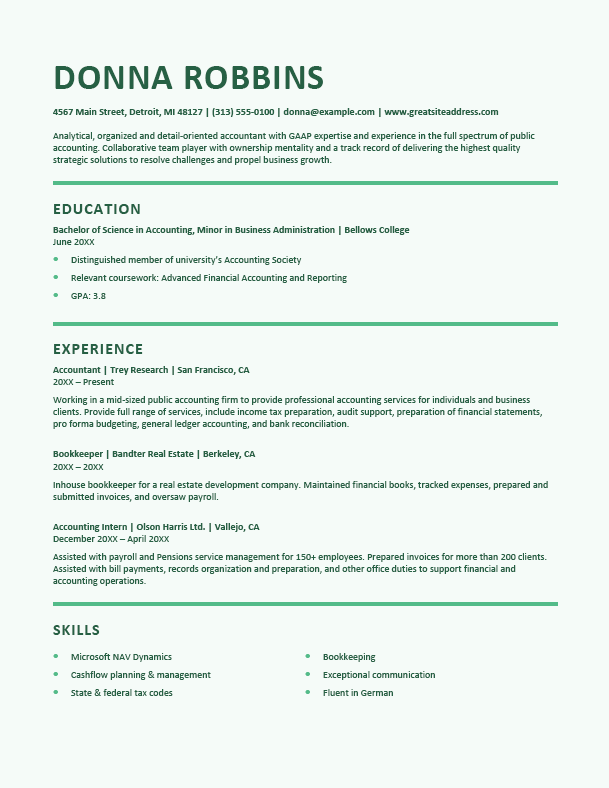

## Load and Transform PDF

In [11]:
from pypdf import PdfReader

def read_pdf(pdf_path):
    pdf_reader = PdfReader(pdf_path)

    raw_text = ""
    for page in pdf_reader.pages:
        content = page.extract_text()
        if content:
            raw_text += content
    return raw_text

In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.indexes.vectorstore import VectorStoreIndexWrapper


pdf_path = "/kaggle/input/test-data/Personal Information.pdf"
model_name = "sentence-transformers/all-mpnet-base-v2"
embedding = HuggingFaceEmbeddings(model_name=model_name, model_kwargs={"device":"cuda"})
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=20)
splitted_text = text_splitter.split_text(read_pdf("/kaggle/input/sample-resume/donna robbins.pdf"))
vector_store = FAISS.from_texts(splitted_text, embedding)
vector_index = VectorStoreIndexWrapper(vectorstore=vector_store)

## Test The RAG Application

In [13]:
# def get_answers(query):
#     answer = vector_index.query(query, llm=llm)
    
#     text_store = []
#     for text in answer.split("Helpful Answer: "):
#         text_store.append(text)
        
#     for x in text_store[-1].split("\n"):
#         print(x)

# get_answers("what she does?")

In [14]:
from langchain.chains import ConversationalRetrievalChain

def question_answering(query):
    chain = ConversationalRetrievalChain.from_llm(
        llm, vector_store.as_retriever(), return_source_documents=True)

    chat_history = []
    answer = chain({"question": query, "chat_history": chat_history})
    
    text_store = []
    for text in answer["answer"].split("Helpful Answer: "):
        text_store.append(text)
        
    for x in text_store[-1].split("\n"):
        print(x)

In [15]:
question_answering("tell me about the candidate")

/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Donna Robbins is a highly qualified and experienced accountant with a strong educational background in accounting and business administration. She has a proven track record of delivering high-quality strategic solutions and has experience in the full spectrum of public accounting. She is analytical, organized, and detail-oriented, with a collaborative team player mentality. She has expertise in GAAP and experience in providing professional accounting services, including income tax preparation, audit support, and financial statement preparation. She also has experience in bookkeeping, cash flow planning, and management, as well as state and federal tax codes. Additionally, she is fluent in German. She has worked in various roles, including as an accountant, bookkeeper, and accounting intern, and has gained experience in different industries, including real estate development and public accounting. Overall, Donna Robbins is a highly qualified and experienced candidate with a strong backg

In [16]:
question_answering("what are the skills the candidate has")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Based on the provided information, Donna Robbins' skills include:

1. Microsoft NAV Dynamics
2. Cash flow planning & management
3. State & federal tax codes
4. Bookkeeping
5. Exceptional communication
6. Fluent in German

Note that the candidate's skills are mentioned in the "SKILLS" section of her resume. If you don't see the answer here, it's because the information is not present in the provided context.


In [17]:
question_answering("where she lives")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


According to the resume, Donna Robbins lives in Detroit, MI 48127. Her address is 4567 Main Street, Detroit, MI 48127. She also mentions that she worked in San Francisco, CA and Berkeley, CA in the past. However, her current residence is in Detroit, MI.


In [18]:
question_answering("any work experience she has?")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Yes, Donna Robbins has three work experiences mentioned in her resume:

1. Accountant at Trey Research, San Francisco, CA (20XX – Present)
2. Bookkeeper at Bandter Real Estate, Berkeley, CA (20XX – 20XX)
3. Accounting Intern at Olson Harris Ltd., Vallejo, CA (December 20XX – April 20XX) | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |


## For Endless Questions

In [19]:
while True:
    query_text = input("Enter Your Questions: ")
    
    if query_text.lower()=="stop":
        break
    if query_text=="":
        continue

    print("Question: ", query_text)
    answer = question_answering(query_text)